# 시계열 분석 기말 과제
> 기말 과제

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [timeseries]

#### 1. 사용할 데이터 : mcopper

In [2]:
library(fpp2)
library(astsa)
library(data.table)
library(ggplot2) 
library(gridExtra)
library(forecast)
library(portes) 
library(fUnitRoots) 
library(tseries) 
library(sarima)
library(lmtest)
library(TTR)

##### (1) 변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.

In [39]:
z <- as.numeric(mcopper)
dt <- data.table(t = seq.Date(as.Date("1984-01-01"), 
             by='month', 
             length.out=length(mcopper)), z = z)

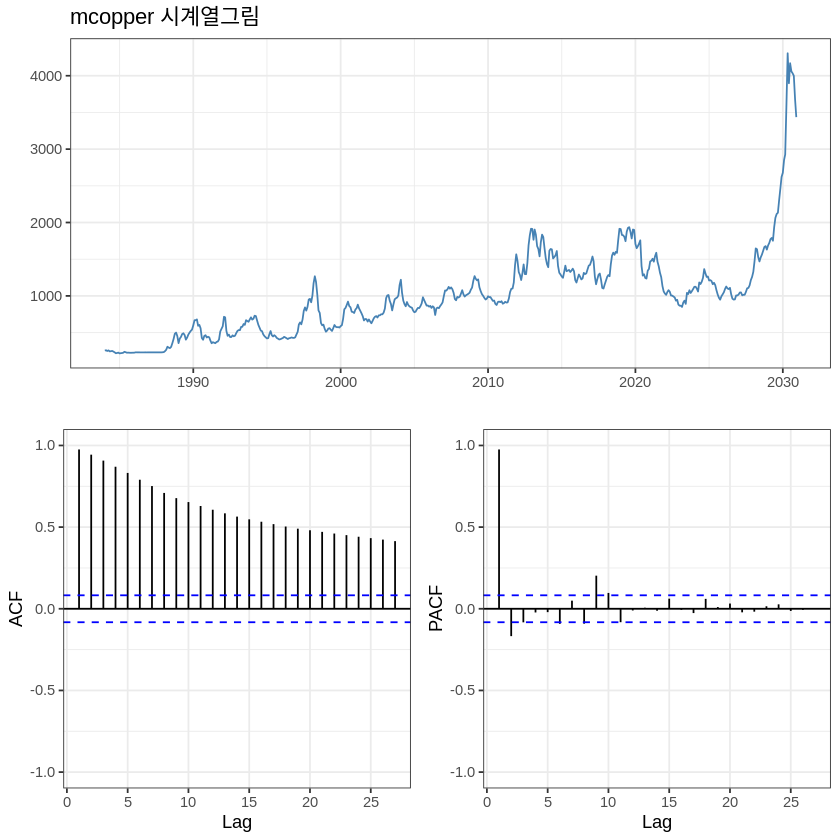

In [40]:
p3 <- ggplot(dt, aes(t, z)) +geom_line(col='steelblue') +xlab("")+ylab('')+ ggtitle('mcopper 시계열그림')+ theme_bw()
p1 <- ggAcf(dt$z) +  theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(dt$z) +   theme_bw() +ylim(-1,1) +  theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2, layout_matrix = rbind(c(1,1), c(2,3)))

- 분산이 일정하지 않은 모습을 보여, 심지어 커지기 때문에 변수 변환이 필요하겠다.

```R
BoxCox.lambda(z, method='loglik')
```
```
0.25
```
- 분산안정화시켜주는 람다값은 0.25가 나왔다.

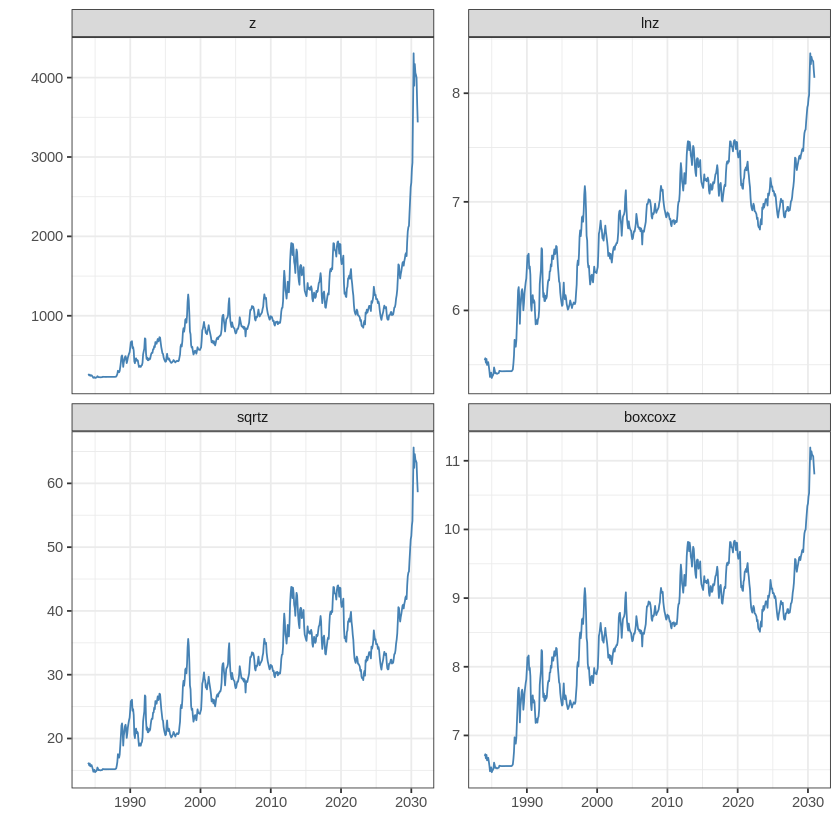

In [41]:
dt[, lnz := log(z)]
dt[, sqrtz := sqrt(z)]
dt[, boxcoxz := BoxCox(z,lambda= BoxCox.lambda(z))]
melt.dt <- melt(dt, id=1)
ggplot(melt.dt, aes(t, value)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ 
  facet_wrap(variable~.,nrow=2, scales = "free_y")+
  theme_bw()

- 시계열 그림을 그려보니 마지막이 독특하게 튀어나온 모습을 볼 수 있었고, 분산 안정화를 통해 정상화가 필요하겠다.
- 그림을 그려보니 trend는 모두 비슷하지만 log 변환이 가장 분산이 안정화되어 보인다.
- 그래서 log 변환을 선택해 사용할 것이다.

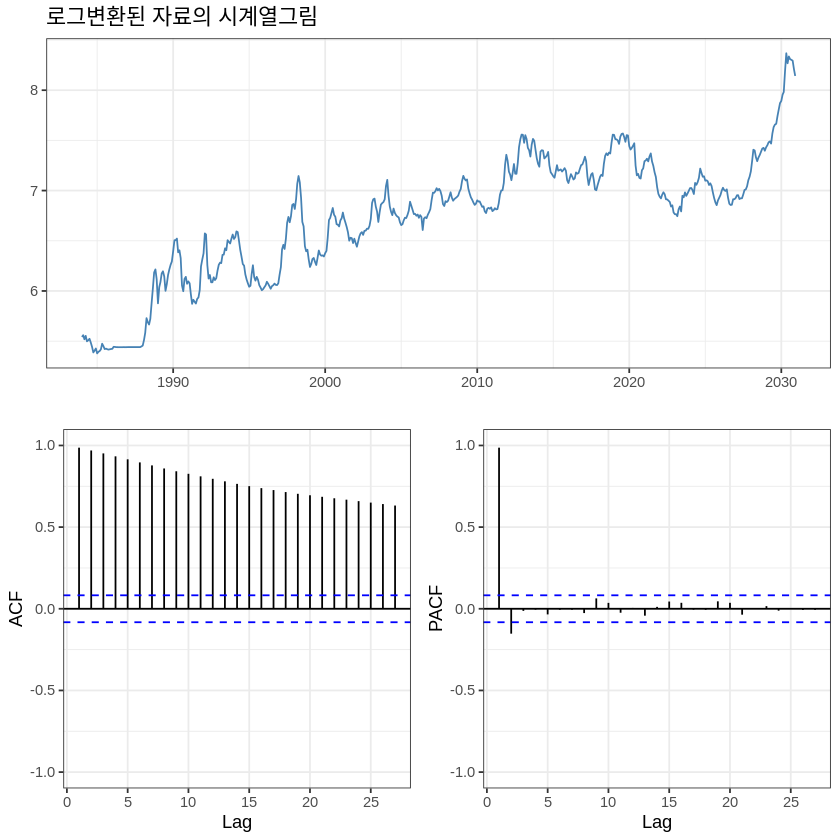

In [42]:
p3 <- ggplot(dt, aes(t, lnz)) +  geom_line(col='steelblue') + xlab("")+ylab('')+ ggtitle('로그변환된 자료의 시계열그림')+ theme_bw()
p1 <- ggAcf(dt$lnz) +  theme_bw() + ylim(-1,1) +  theme(plot.title = element_blank())
p2 <- ggPacf(dt$lnz) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2, layout_matrix = rbind(c(1,1),   c(2,3)))

- 로그 변환을 통해 분산 안정화를 했더니 ACF 가 천천히 지수적으로 감소하여 차분이 필요할 것 같다.

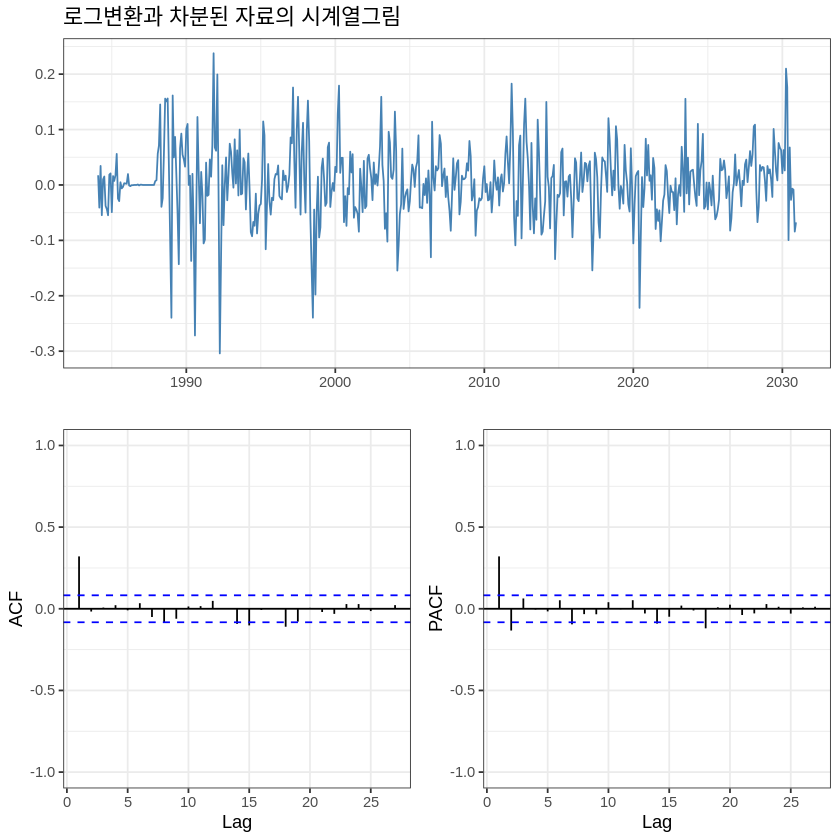

In [43]:
dt[, df1_lnz := c(0, diff(lnz))]
ddt <- dt[-1,]
p3 <- ggplot(ddt, aes(t, df1_lnz)) + geom_line(col='steelblue') +  xlab("")+ylab('')+ ggtitle('로그변환과 차분된 자료의 시계열그림')+ theme_bw()
p1 <- ggAcf(ddt$df1_lnz) + theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(ddt$df1_lnz) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2, layout_matrix = rbind(c(1,1), c(2,3)))

- 차분 후 시계열 그림을 보면 추세는 없고, 평균도 0 인것처럼보인다.
- 따라서 단위근 검정 시 상수항 없는 단위근 검정 type 옵션 nc 를 사용할 것이다.
- ACF는 1 시차 이후 절단된 형태였다.
- PACF는 빠르게 지수적으로 감소하고 있었다.

In [44]:
adfTest(ddt$df1_lnz, lags = 0, type = "nc")
adfTest(ddt$df1_lnz, lags = 1, type = "nc")
adfTest(ddt$df1_lnz, lags = 2, type = "nc")

Warning message in adfTest(ddt$df1_lnz, lags = 0, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -16.8919
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:34 2021 by user: 


Warning message in adfTest(ddt$df1_lnz, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -15.6202
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:34 2021 by user: 


Warning message in adfTest(ddt$df1_lnz, lags = 2, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -12.1536
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:34 2021 by user: 


- 단위근 검정을 해보아도 모두 기각하여 단위근이 없다는 결론이 나왔다.
- 따라서 추가적인 차분이 필요하지 않겠다.

##### (2) auto.arima 를 이용하여 예측 모형을 적합하여라. (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

In [45]:
auto.arima(ddt$df1_lnz, trace=T, ic='aic')


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -1560.687
 ARIMA(0,0,0) with non-zero mean : -1490.851
 ARIMA(1,0,0) with non-zero mean : -1549.084
 ARIMA(0,0,1) with non-zero mean : -1561.528
 ARIMA(0,0,0) with zero mean     : -1489.941
 ARIMA(1,0,1) with non-zero mean : -1558.813
 ARIMA(0,0,2) with non-zero mean : -1559.55
 ARIMA(1,0,2) with non-zero mean : Inf
 ARIMA(0,0,1) with zero mean     : -1561.763
 ARIMA(1,0,1) with zero mean     : -1559.133
 ARIMA(0,0,2) with zero mean     : -1559.768
 ARIMA(1,0,0) with zero mean     : -1549.658
 ARIMA(1,0,2) with zero mean     : -1561.107

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,0,1) with zero mean     : -1561.685

 Best model: ARIMA(0,0,1) with zero mean     



Series: ddt$df1_lnz 
ARIMA(0,0,1) with zero mean 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02

- auto.arima를 적용해보았다.
- 상수항 없는 ARIMA(0.0.1) 모형이 제일 적합하다는 결론이 나와 예측 모형을 적합해 보았다.

In [46]:
fit = arima(ddt$df1_lnz, order = c(0,0,1), include.mean = F)

In [47]:
summary(fit)


Call:
arima(x = ddt$df1_lnz, order = c(0, 0, 1), include.mean = F)

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

Training set error measures:
                      ME       RMSE        MAE MPE MAPE      MASE         ACF1
Training set 0.003338041 0.06023162 0.04317384 NaN  Inf 0.8013751 -0.004110819

- 모형 적합 결과에서 coeff가 Se보다 크기 때문에 유의하지 않다는 근거가 생겼다.
- AIC 값은 -1561.69 가 나왔고,log-likelihood 값은 782.84 가 나왔다.

In [48]:
coeftest(fit)


z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ma1 0.375553   0.038466  9.7631 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- 위에서 로그변환 후 차분을 한 번 해줬기 때문에 원자료에 대해 모형을 표현하자면,
- $ARIMA(0,1,1)(0,0,0)_0$ 모수추정값: 0.3756
- $(1-B)lnZ_t=(1-0.3756)\epsilon_t$

##### (3) (2)번 모형을 제외한 다른 후보 모형을 선택하여 적합하여라 . (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

- 로그변환후 차분한 데이터의 ACF,PACF 그림만 보면 ACF가 1 시차 이후 절단되었고, PACF가 지수적으로 서서히 감소하는 것처럼 보이기 때문에
- $ARIMA(0,0,1)$ 모형이 적절해 보이지만, (2)에서 이미 적합해 본 모형이기 때문에 다른 모형을 적합해보았다.
- 로그변환 후 차분한 모형에 상수항 없는 $ARIMA(1,0,0)$ 모형을 적합해보았다.

In [49]:
fit2 = arima(ddt$df1_lnz, order = c(1,0,0), include.mean = F)

In [50]:
summary(fit2)


Call:
arima(x = ddt$df1_lnz, order = c(1, 0, 0), include.mean = F)

Coefficients:
         ar1
      0.3243
s.e.  0.0398

sigma^2 estimated as 0.003701:  log likelihood = 777.24,  aic = -1550.47

Training set error measures:
                      ME       RMSE        MAE MPE MAPE      MASE       ACF1
Training set 0.003079992 0.06083653 0.04342194 NaN  Inf 0.8059801 0.03994371

- 모형 적합 결과에서 coeff가 Se보다 크기 때문에 유의하지 않다는 근거가 생긴다.
- AIC 값은 -1550.47이 나왔고, log likelihood 값은 777.24가 나왔다.

In [51]:
coeftest(fit2)


z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ar1 0.324265   0.039849  8.1373 4.044e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- 해당 모형도 원자료에 대해 모형을 표현하자면,
- $ARIMA(1,1,0)(0,0,0)_0$ 모수추정값: 0.324265
- $(1-0.3243B)(1-B)lnZ_t=\epsilon_t$

##### (4) (2),(3)번 모형 중 어떤 모형일 더 적절한지 설명하여라.

- (2)
    - $ARIMA(0,1,1)(0,0,0)_0$ 모수추정값: 0.3756
    - $(1-B)lnZ_t=(1-0.3756)\epsilon_t$
    - $AIC$ 값은 -1561.69 가 나왔고,$log-likelihood$ 값은 782.84 가 나왔다.

- (3)
   - $ARIMA(1,1,0)(0,0,0)_0$ 모수추정값: 0.3243
   - $(1-0.3243B)(1-B)lnZ_t=\epsilon_t$
   - $AIC$ 값은 -1550.47이 나왔고, $log likelihood$ 값은 777.24가 나왔다.

- AIC값은 (2)에서 적합한 모형이 더 작다.
- log likelihood 값은 (2)에서 적합한 모형이 더 크다.
- 따라서 (2)모형을 선택하였다.

##### (5) (4)에서 선택한 모형을 이용하여 잔차검정을 시행하여라.

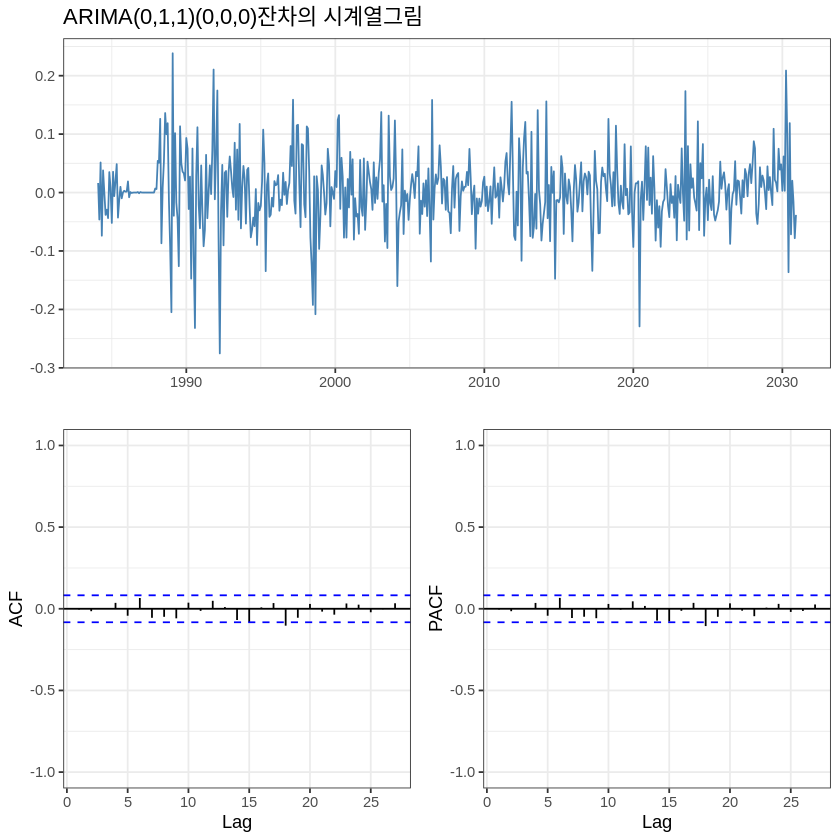

In [52]:
ddt[, res := as.numeric(resid(fit))]
p3 <- ggplot(ddt, aes(t, res)) +  geom_line(col='steelblue') + xlab("")+ylab('')+ ggtitle('ARIMA(0,1,1)(0,0,0)잔차의 시계열그림')+ theme_bw()
p1 <- ggAcf(ddt$res) +  theme_bw() + ylim(-1,1) +  theme(plot.title = element_blank())
p2 <- ggPacf(ddt$res) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,  layout_matrix = rbind(c(1,1), c(2,3)))

- 잔차 plot이 잘 흩어져 있는 모습이지만, 등분산인지는 애매하다.
- ACF와 PACF가 모두 유의하지 않은 모습이었다. 백색소음!

In [53]:
dwtest(ddt$res~1)


	Durbin-Watson test

data:  ddt$res ~ 1
DW = 2.0073, p-value = 0.5345
alternative hypothesis: true autocorrelation is greater than 0


- 더빈왓슨 검정 결과 p값은 유의하지 않아 자기상관관계가 없다고 할 수 있다.

In [54]:
LjungBox(fit, lags=seq(6,24,6))

,lags,statistic,df,p-value
,6,4.385991,5,0.49528078
,12,11.752528,11,0.38252950
,18,25.468187,17,0.08471006
,24,29.664346,23,0.15928170


- 잔차의 포트맨토 검정 결과도 모두 유의하지 않은 모습이었다.

In [55]:
shapiro.test(ddt$res) 


	Shapiro-Wilk normality test

data:  ddt$res
W = 0.96394, p-value = 1.59e-10


- 정규성 가정을 만족하지 않은 모습이다.

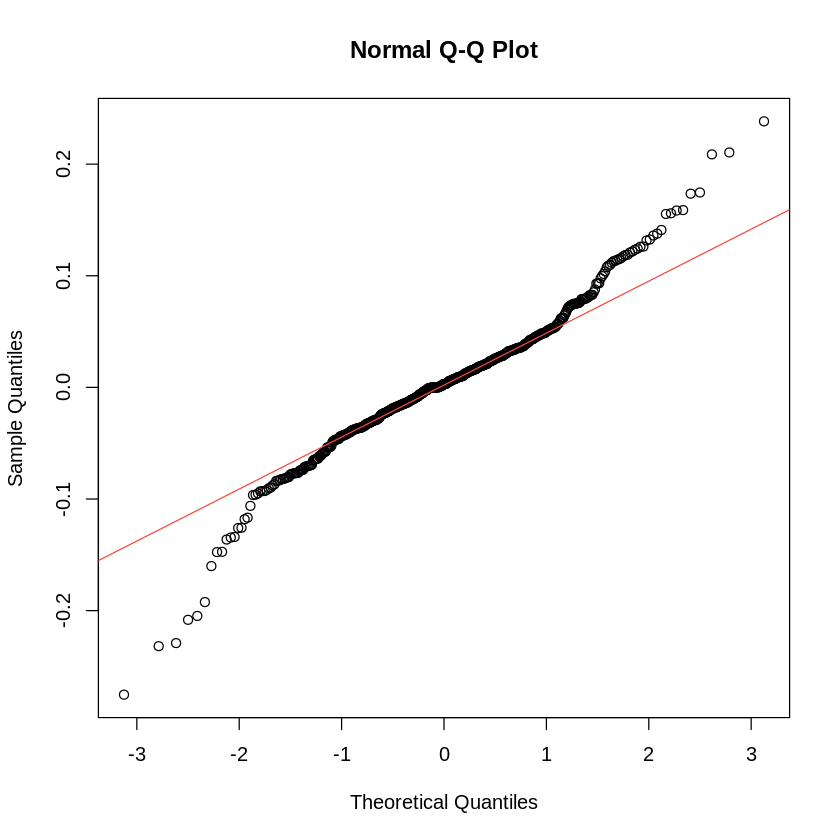

In [56]:
qqnorm(ddt$res)
qqline(ddt$res, col = 2)

- qqplot을 보니 직선 가운데는 잘 맞지만 꼬리 쪽에서 직선을 벗어난 모습을 볼 수 있었다.

##### (6) 2007년과 2008년 데이터를 예측하여라

$pred
Time Series:
Start = 565 
End = 589 
Frequency = 1 
 [1] 8.131042 8.135663 8.140284 8.144905 8.149526 8.154147 8.158768 8.163389
 [9] 8.168010 8.172631 8.177252 8.181873 8.186493 8.191114 8.195735 8.200356
[17] 8.204977 8.209598 8.214219 8.218840 8.223461 8.228082 8.232703 8.237324
[25] 8.241945

$se
Time Series:
Start = 565 
End = 589 
Frequency = 1 
 [1] 0.06013797 0.10218248 0.13139993 0.15521155 0.17582749 0.19426783
 [7] 0.21110347 0.22669221 0.24127586 0.25502690 0.26807351 0.28051397
[13] 0.29242567 0.30387078 0.31490020 0.32555617 0.33587424 0.34588464
[19] 0.35561337 0.36508294 0.37431302 0.38332091 0.39212192 0.40072969
[25] 0.40915641

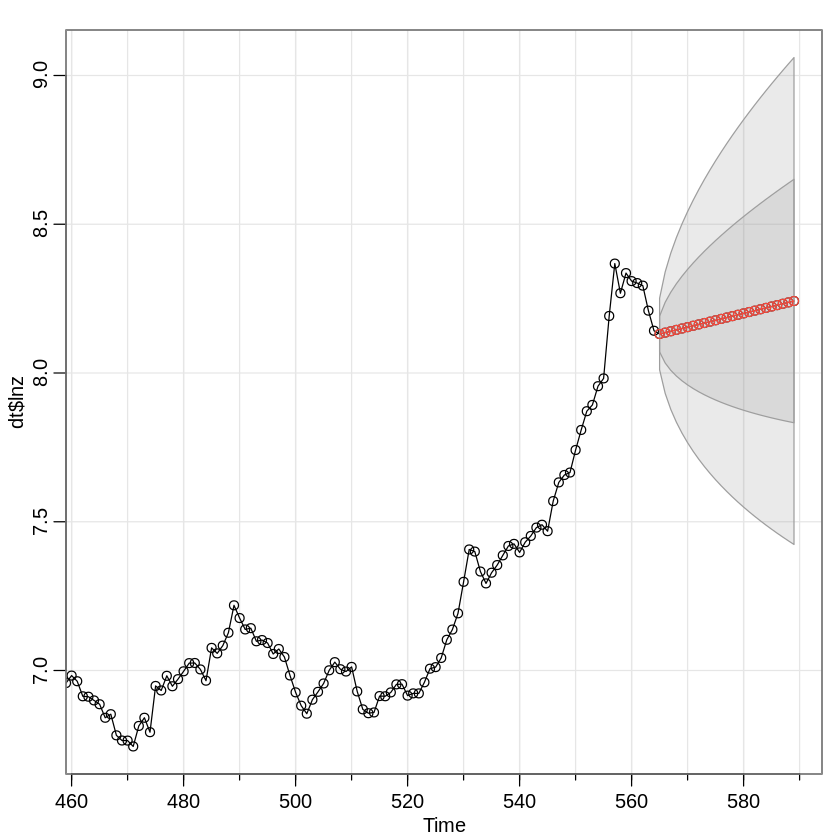

In [57]:
sarima.for(dt$lnz, 25, 0,1,1) 

- mcopper 데이터가 2006년까지 있고, 월단위로 데이터가 있기 때문에 24이상의 값을 입력하여 2007년과 2008년 데이터를 예측해보았다.

$pred
Time Series:
Start = 564 
End = 588 
Frequency = 1 
 [1] -0.01096287  0.00462094  0.00462094  0.00462094  0.00462094  0.00462094
 [7]  0.00462094  0.00462094  0.00462094  0.00462094  0.00462094  0.00462094
[13]  0.00462094  0.00462094  0.00462094  0.00462094  0.00462094  0.00462094
[19]  0.00462094  0.00462094  0.00462094  0.00462094  0.00462094  0.00462094
[25]  0.00462094

$se
Time Series:
Start = 564 
End = 588 
Frequency = 1 
 [1] 0.06013797 0.06420001 0.06420001 0.06420001 0.06420001 0.06420001
 [7] 0.06420001 0.06420001 0.06420001 0.06420001 0.06420001 0.06420001
[13] 0.06420001 0.06420001 0.06420001 0.06420001 0.06420001 0.06420001
[19] 0.06420001 0.06420001 0.06420001 0.06420001 0.06420001 0.06420001
[25] 0.06420001

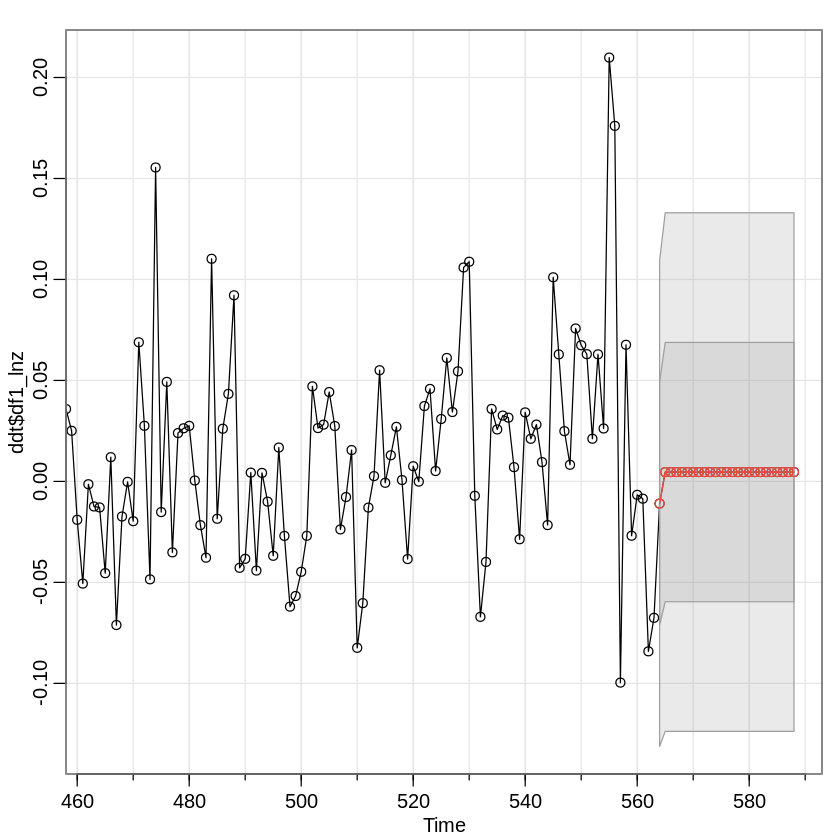

In [58]:
sarima.for(ddt$df1_lnz, 25, 0,0,1) 

- 로그변환 후 1차 차분한 데이터에 대해서도 예측값을 구해보았다.
- MA(1)모형의 예측값이 n+1 시차 이후 표본평균(0)에 수렴하는 모습이었다.

#### 2. 사용할 데이터 : hsales

##### (1) 변수변환이 필요한지를 설명하고 , 필요하다면 적절한 변수 변환을 하여라 

In [59]:
z<-as.numeric(hsales)
length(z)

[1] 275

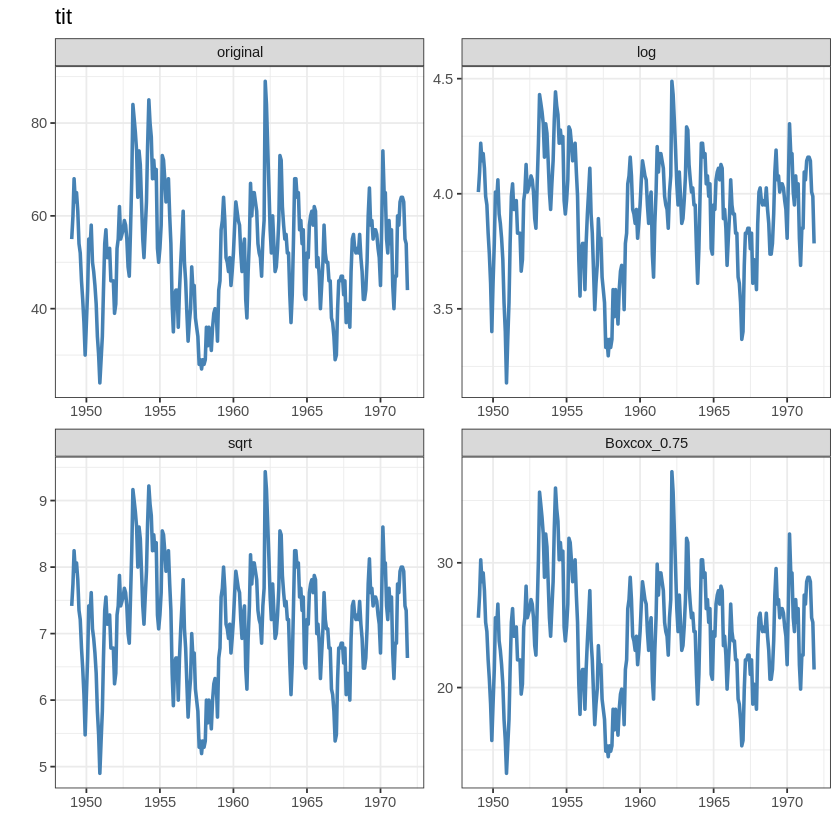

In [60]:
tmp.dat <- data.table(t=seq.Date(as.Date("1949-01-01"),by='month',length.out=275),
  original=z, log = log(z), sqrt = sqrt(z),
  Boxcox_0.75 = BoxCox(z,lambda= BoxCox.lambda(z, method='loglik')) 
)
melt.tmp <- melt(tmp.dat, id=1)
ggplot(melt.tmp, aes(t,value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("tit")+
  theme_bw()+
  facet_wrap(.~variable, nrow = 2, scales = "free")

- 로그변환이 필요해보여 로그변환한 데이터를 사용할 예정이다.

##### (2) 데이터가 정상시계열인가 ? 아니면 적절한 차분을 통해 정상시계열로 변환하여라 .

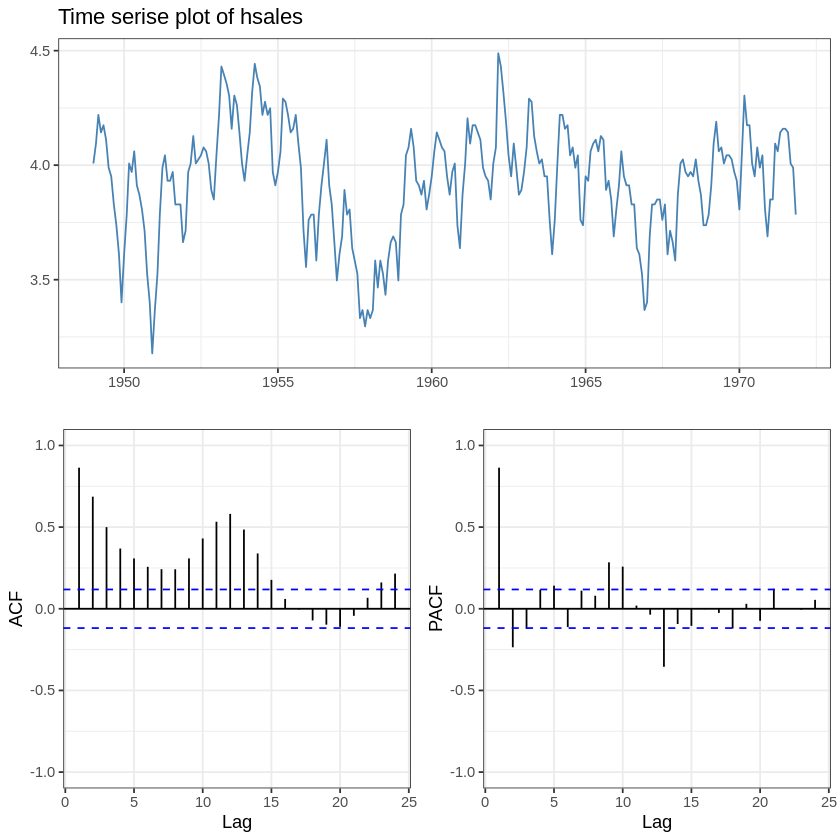

In [61]:
p3 <- ggplot(tmp.dat, aes(t, log)) +  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('Time serise plot of hsales')+
  theme_bw()
p1 <- ggAcf(tmp.dat$log) +  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())
p2 <- ggPacf(tmp.dat$log) + theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1), c(2,3)))

- 추세가 없어보임, 평균이 4인 것 같다.
- ACF가 빠르게 감소하고 있는 것처럼 보이면서 산처럼 솟은 곳이 보여 계절차분을 해도 되겠다.
- 혹은 ACF가 천천히 감소한다고 보고 차분을 먼저 해볼 수도 있겠다.
- PACF 1 이후 유의한 부분이 보인다. 아마 ACF에서 판단한 것처럼 계절차분이 필요하기 때문이지 않을까? 
- 혹은 ACF가 빠르게 감소한다고 보고, PACF를 1시차에서 절단된다고 봐서 AR(1) 모형을 적합해보는 방법도 고려해봤다.

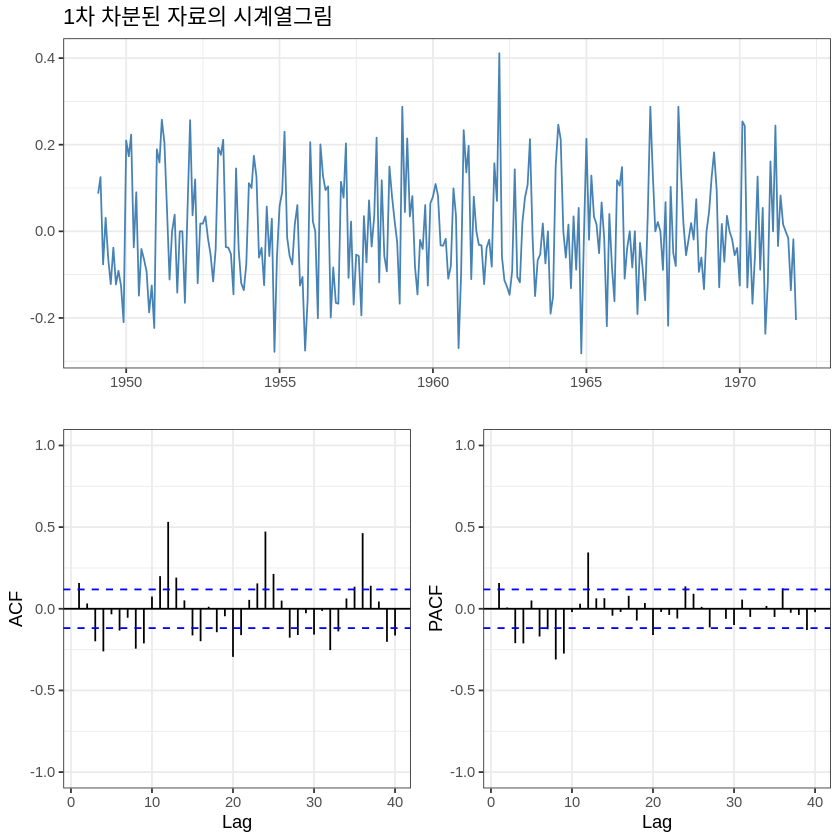

In [62]:
tmp.dat[, df1_lnz := c(0, diff(log))]
dt <- tmp.dat[-1,]
p3 <- ggplot(dt, aes(t, df1_lnz)) +  geom_line(col='steelblue') + xlab("")+ylab('')+ ggtitle('1차 차분된 자료의 시계열그림')+ theme_bw()
p1 <- ggAcf(dt$df1_lnz, lag.max = 40) +   theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(dt$df1_lnz, lag.max = 40) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,   layout_matrix = rbind(c(1,1),    c(2,3)))

- 1차 차분 후 plot을 보니 위에서 예측한대로 계절주기가 보이는 것 같다.
- 즉, 우똑 솟은 유의한 값 양쪽으로도 유의한 모습을 보이고 있었다.
- 시계열 plot에서 일단 계절성이 뚜렷하고, ACF에서 주기 주변으로 유의한 값이 있는 모습, 그리고 PACF도 계절 주기에 해당되는 시차에서 서서히 감소하고 있어 계절차분이 추가로 필요함을 알 수 있었다.

In [63]:
adfTest(dt$df1_lnz, lags = 0, type = "ct")
adfTest(dt$df1_lnz, lags = 1, type = "ct")
adfTest(dt$df1_lnz, lags = 2, type = "ct")

Warning message in adfTest(dt$df1_lnz, lags = 0, type = "ct"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -13.9323
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:42 2021 by user: 


Warning message in adfTest(dt$df1_lnz, lags = 1, type = "ct"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -10.5206
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:42 2021 by user: 


Warning message in adfTest(dt$df1_lnz, lags = 2, type = "ct"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -10.8691
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:42 2021 by user: 


- 단위근 검정을 해보니 p 값이 모두 작아 모두 기각하였으며, 단위근이 없다는 결론이 나왔다.

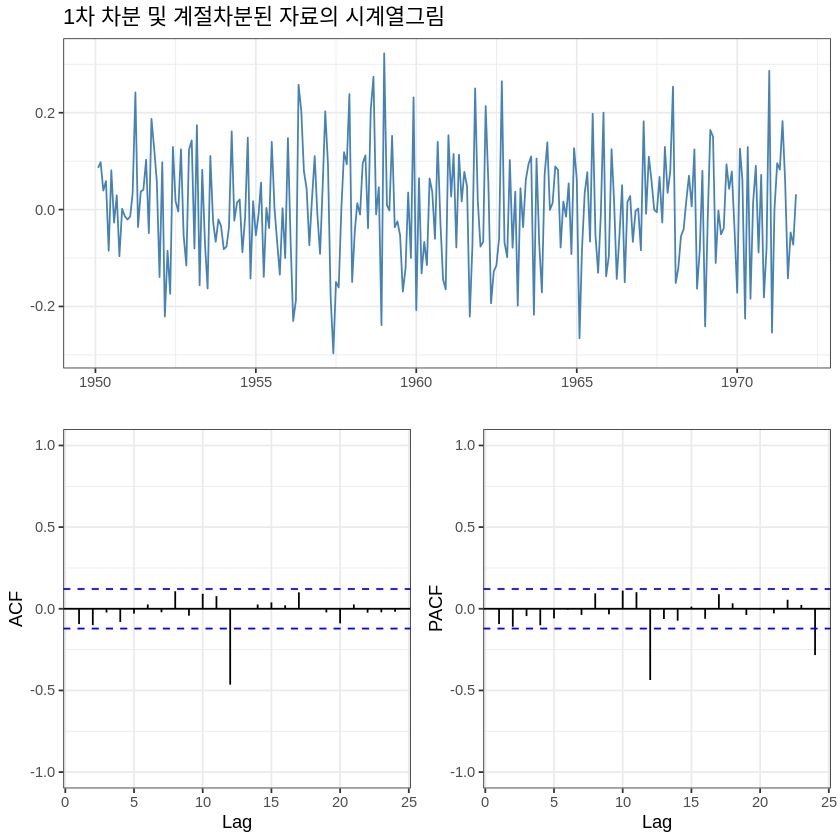

In [64]:
dt[, df12_df1_lnz := c(rep(0,12), diff(df1_lnz,12))]
sdt <- dt[-(1:12)]
p3 <- ggplot(sdt, aes(t, df12_df1_lnz)) + geom_line(col='steelblue') +xlab("")+ylab('')+ ggtitle('1차 차분 및 계절차분된 자료의 시계열그림')+theme_bw()
p1 <- ggAcf(sdt$df12_df1_lnz) + theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(sdt$df12_df1_lnz) +  theme_bw() +ylim(-1,1) +theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,   layout_matrix = rbind(c(1,1), c(2,3)))

- 1차 차분 및 계절차분된 시계열 plot은 평균이 0인인 것처럼 보이며,
- ACF는 12에서만 유의하며,
- PACF는 12,24에서 주기적으로 유의한 값을 띄었다.
- 정상성을 띄고 있는 것으로 보면서,
- 동시에 상수항이 없는 $ARIMA(0,0,0)(0,0,1)_{12}$ 모형 잠정모형으로 적절할 것 같다는 생각을 했다.

In [65]:
adf.test(sdt$df12_df1_lnz)

Warning message in adf.test(sdt$df12_df1_lnz):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  sdt$df12_df1_lnz
Dickey-Fuller = -7.1756, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


In [66]:
adfTest(sdt$df12_df1_lnz, lags = 0, type = "c")
adfTest(sdt$df12_df1_lnz, lags = 1, type = "c")
adfTest(sdt$df12_df1_lnz, lags = 2, type = "c")

Warning message in adfTest(sdt$df12_df1_lnz, lags = 0, type = "c"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -17.6955
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:43 2021 by user: 


Warning message in adfTest(sdt$df12_df1_lnz, lags = 1, type = "c"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -13.2921
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:43 2021 by user: 


Warning message in adfTest(sdt$df12_df1_lnz, lags = 2, type = "c"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -10.6921
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:43 2021 by user: 


- 단위 검정 결과 모두 기각하여 단위근이 없다는 결과가 나왔다.
- 분산이 안정화되어 있고, 차분이 필요하지 않아 정상시계열로 변환된 것 같다.

##### (3) 모형을 식별하여라 . (2 개 이상의 모형 고려 )( 형태 : ARIMA( p.d.q )(P,D,Q)s )

- (2)에서 예측한대로 상수항이 없는 $ARIMA(0,0,0)(0,0,1)_{12}$ 모형이 적절해 보인다. 이때 이 잠정 모형은 1차 차분 및 계절차분에서 나온 값이기 때문에 $ARIMA(0,1,0)(0,1,1)_{12}$ 모형을 잠정모형으로 선택하였다.
- 혹은 계절 차분 전 ACF 및 PACF 를 보아 상수항 없는 $ARIMA(0,0,1)(1,0,0)_{12}$ 모형도 적합해볼 수 있겠다. 이때도 1차 차분한 데이터에서 추정한 것이기 때문에 모형 적합에서는 $ARIMA(0,1,1)(1,0,0)_{12}$ 모형을 선택하였다.
- 추가로, $ARIMA(0,1,1)(0,1,1)_{12}$ 모형과 $ARIMA(0,1,2)(1,0,0)_{12}$ 모형을 잠정모형으로 선택하였다.

##### (4) (3) 에서 고려한 모형을 적합하여라 . ( 형태 : ARIMA( p.d.q )(P,D,Q)s, 모수추정값 )

In [67]:
### ARIMA(0,1,0)(0,1,1)_12
fit1 = arima(tmp.dat$log, order = c(0,1,0), seasonal = list(order = c(0,1,1), period = 12))
summary(fit1)
coeftest(fit1)


Call:
arima(x = tmp.dat$log, order = c(0, 1, 0), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
         sma1
      -0.9999
s.e.   0.0801

sigma^2 estimated as 0.007124:  log likelihood = 257.18,  aic = -510.35

Training set error measures:
                      ME       RMSE        MAE        MPE     MAPE    MASE
Training set 0.003952528 0.08239128 0.06409028 0.08562818 1.645261 0.64136
                   ACF1
Training set -0.1038561


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
sma1 -0.999931   0.080144 -12.477 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- AIC 값은 -510.35이 나왔다.
- log likelihood는 257.18 이 나왔고,
- 모형 적합 결과에서 coef에 비해 se가 커 유의하지 않다는 근거가 생겼다.
- 모수 추정값은 sma1=-1.0000 이 나왔다.

In [68]:
## ARIMA(0,1,1)(1,0,0)_12
fit2 = arima(tmp.dat$log, order = c(0,1,1), seasonal = list(order = c(1,0,0), period = 12))
summary(fit2)
coeftest(fit2)


Call:
arima(x = tmp.dat$log, order = c(0, 1, 1), seasonal = list(order = c(1, 0, 0), 
    period = 12))

Coefficients:
          ma1    sar1
      -0.0159  0.5568
s.e.   0.0669  0.0523

sigma^2 estimated as 0.01071:  log likelihood = 230.54,  aic = -455.08

Training set error measures:
                        ME     RMSE        MAE         MPE     MAPE      MASE
Training set -0.0001440728 0.103285 0.08322797 -0.03452234 2.137522 0.8328734
                      ACF1
Training set -0.0002914348


z test of coefficients:

      Estimate Std. Error z value Pr(>|z|)    
ma1  -0.015890   0.066903 -0.2375   0.8123    
sar1  0.556769   0.052312 10.6433   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- AIC 값은 -455.08가 나왔다.
- log likelihood 는 230.54 이 나왔다.
- 모형 적합 결과에서 ma1 은 coef에 비해 se가 커 유의하지 않다는 근거가 생겼지만 sar1은 유의하였다.
- 모수 추정값은 ma1=-0.0159, sar1= 0.5568 가 나왔다.

In [69]:
### ARIMA(0,1,1)(0,1,1)_12
fit3 = arima(tmp.dat$log, order = c(0,1,1), seasonal = list(order = c(0,1,1), period = 12))
summary(fit3)
coeftest(fit3)


Call:
arima(x = tmp.dat$log, order = c(0, 1, 1), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
          ma1     sma1
      -0.1111  -1.0000
s.e.   0.0656   0.0765

sigma^2 estimated as 0.007046:  log likelihood = 258.6,  aic = -511.21

Training set error measures:
                      ME       RMSE        MAE        MPE     MAPE      MASE
Training set 0.004407847 0.08194001 0.06413126 0.09625902 1.647035 0.6417701
                      ACF1
Training set -0.0006868962


z test of coefficients:

      Estimate Std. Error z value Pr(>|z|)    
ma1  -0.111134   0.065604  -1.694  0.09026 .  
sma1 -0.999971   0.076478 -13.075  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- AIC 값은 -511.21가 나왔다.
- log likelihood 는 258.6 이 나왔다.
- 모형 적합 결과에서 모두 coef에 비해 se가 커 유의하지 않다는 근거가 생겼다.
- 모수 추정값은 ma1=-0.1111, sma1=-1.0000 이 나왔다.

In [70]:
## ARIMA(0,1,2)(1,0,0)_12
fit4 = arima(tmp.dat$log, order = c(0,1,2), seasonal = list(order = c(1,0,0), period = 12))
summary(fit4)
coeftest(fit4)


Call:
arima(x = tmp.dat$log, order = c(0, 1, 2), seasonal = list(order = c(1, 0, 0), 
    period = 12))

Coefficients:
          ma1      ma2    sar1
      -0.0351  -0.0854  0.5696
s.e.   0.0654   0.0749  0.0524

sigma^2 estimated as 0.01065:  log likelihood = 231.18,  aic = -454.37

Training set error measures:
                        ME      RMSE        MAE         MPE     MAPE      MASE
Training set -5.319939e-05 0.1029906 0.08372574 -0.03538974 2.150165 0.8378547
                    ACF1
Training set 0.007026794


z test of coefficients:

      Estimate Std. Error z value Pr(>|z|)    
ma1  -0.035132   0.065441 -0.5369   0.5914    
ma2  -0.085427   0.074919 -1.1403   0.2542    
sar1  0.569623   0.052363 10.8784   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- AIC 값은 -454.37가 나왔다.
- log likelihood 는 231.18 이 나왔다.
- 모형 적합 결과에서 ma1,ma2 은 coef에 비해 se가 커 유의하지 않다는 근거가 생겼다. 하지만 sar1은 유의했다.
- 모수 추정값은 ma1= -0.0351, ma2=-0.0854, sar1= 0.5696 이 나왔다.

##### (5) (4) 에서 적합된 결과를 이용하여 더 좋은 모형을 선택하여라 .

- $ARIMA(0,1,1)(0,1,1)_{12}$
- 모형의 AIC 값이 가장 작게 나왔고, log liklihood 도 가장 크게 나왔다.
- 또한 coeff 도 유의하지 않았다.
- 따라서 fit3 모형을 선택했다.

##### (6) (5) 에서 선택한 모형을 이용하여 잔차검정을 시행하여라 .

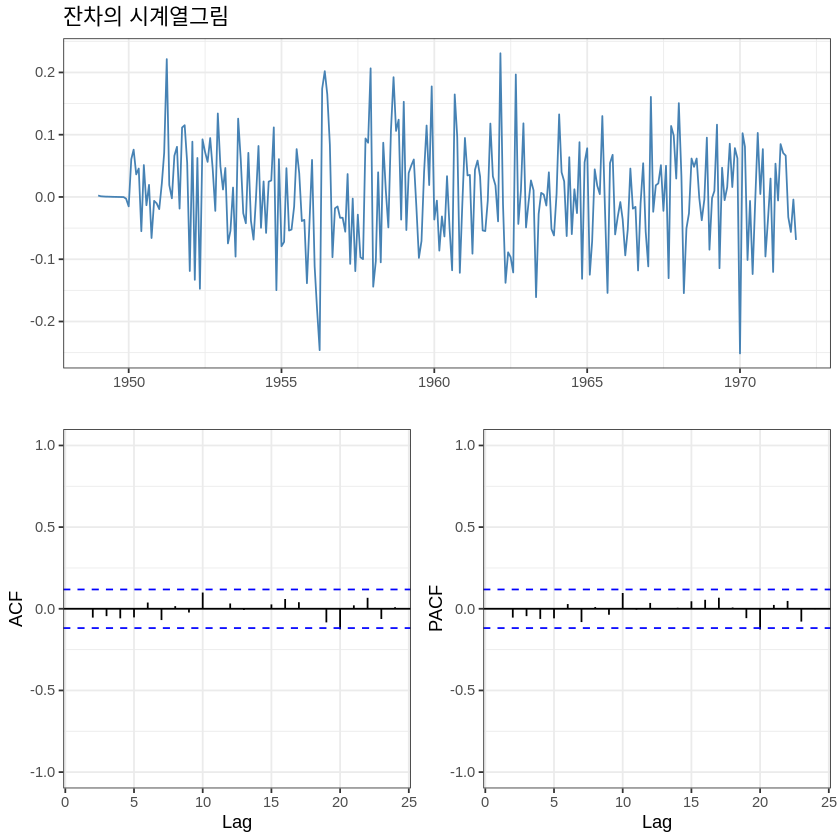

In [71]:
tmp.dat[, res := as.numeric(resid(fit3))]
p3 <- ggplot(tmp.dat, aes(t, res)) + geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+ theme_bw()
p1 <- ggAcf(tmp.dat$res) + theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(tmp.dat$res) + theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,  layout_matrix = rbind(c(1,1), c(2,3)))

- 잔차 plot을 보니 평균이 0인 것 같지만 분산이 정말 안정한지 애매하다.
- ACF, PACF 에서 유의한 값은 보이지 않았다.

In [72]:
dwtest(tmp.dat$res~1)


	Durbin-Watson test

data:  tmp.dat$res ~ 1
DW = 1.9984, p-value = 0.4948
alternative hypothesis: true autocorrelation is greater than 0


- 더빈왓슨 검정 결과 p값은 유의하지 않아 자기상관관계가 없다고 할 수 있다.

In [73]:
LjungBox(fit3, lags=seq(6,24,6))

,lags,statistic,df,p-value
,6,3.537554,4,0.4721911
,12,8.278001,10,0.6017023
,18,10.049570,16,0.8640268
,24,19.568612,22,0.6100041


- 잔차의 포트맨토검정 결과 6시차를 제외하고 유의하지 않은 모습이었다.

In [74]:
shapiro.test(tmp.dat$res) 


	Shapiro-Wilk normality test

data:  tmp.dat$res
W = 0.99548, p-value = 0.6062


- 정규성 검정 결과 p값이 0.0249로 정규성 가정을 만족하는 모습이다.

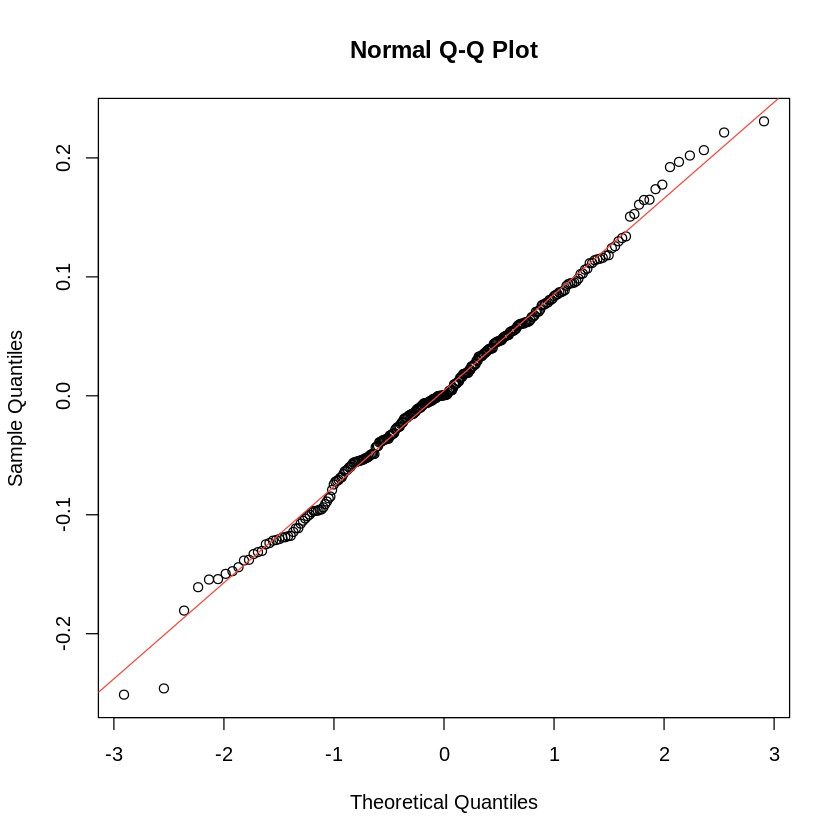

In [75]:
qqnorm(tmp.dat$res)
qqline(tmp.dat$res, col = 2)

- qqplot을 보니 가운데는 직선에 잘 맞는 모습이었다.

##### (7) 다음 2년간의 값을 예측하여라 .

$pred
Time Series:
Start = 276 
End = 300 
Frequency = 1 
 [1] 3.753988 3.753112 3.752236 3.751361 3.750485 3.749609 3.748733 3.747858
 [9] 3.746982 3.746106 3.745230 3.744354 3.743479 3.742603 3.741727 3.740851
[17] 3.739976 3.739100 3.738224 3.737348 3.736472 3.735597 3.734721 3.733845
[25] 3.732969

$se
Time Series:
Start = 276 
End = 300 
Frequency = 1 
 [1] 0.1229456 0.1867775 0.2337864 0.2728118 0.3069145 0.3375896 0.3657007
 [8] 0.3917999 0.4162660 0.4393719 0.4613219 0.4822739 0.5023528 0.5216594
[15] 0.5402766 0.5582732 0.5757076 0.5926293 0.6090810 0.6250999 0.6407184
[22] 0.6559652 0.6708655 0.6854421 0.6997150

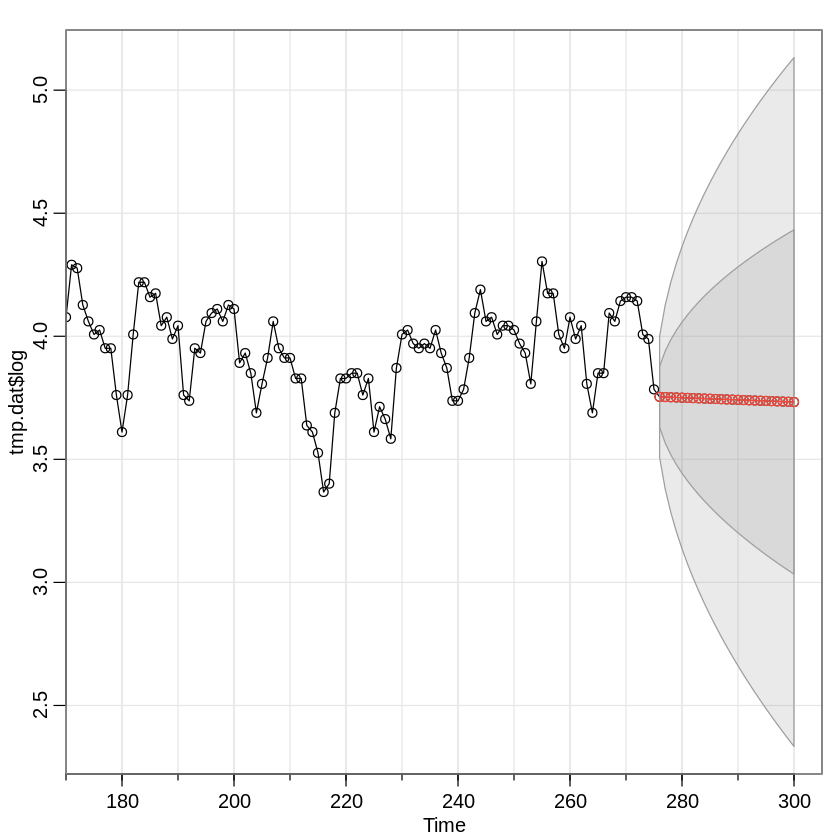

In [76]:
sarima.for(tmp.dat$log, 25, 0,1,1)

- hsales 데이터는 1972년부터 달마다 데이터가 있기 때문에 24 이상 써서 예측값을 구해보았다.

$pred
Time Series:
Start = 275 
End = 299 
Frequency = 1 
 [1] -0.0302016203 -0.0008757759 -0.0008757759 -0.0008757759 -0.0008757759
 [6] -0.0008757759 -0.0008757759 -0.0008757759 -0.0008757759 -0.0008757759
[11] -0.0008757759 -0.0008757759 -0.0008757759 -0.0008757759 -0.0008757759
[16] -0.0008757759 -0.0008757759 -0.0008757759 -0.0008757759 -0.0008757759
[21] -0.0008757759 -0.0008757759 -0.0008757759 -0.0008757759 -0.0008757759

$se
Time Series:
Start = 275 
End = 299 
Frequency = 1 
 [1] 0.1229456 0.1242076 0.1242076 0.1242076 0.1242076 0.1242076 0.1242076
 [8] 0.1242076 0.1242076 0.1242076 0.1242076 0.1242076 0.1242076 0.1242076
[15] 0.1242076 0.1242076 0.1242076 0.1242076 0.1242076 0.1242076 0.1242076
[22] 0.1242076 0.1242076 0.1242076 0.1242076

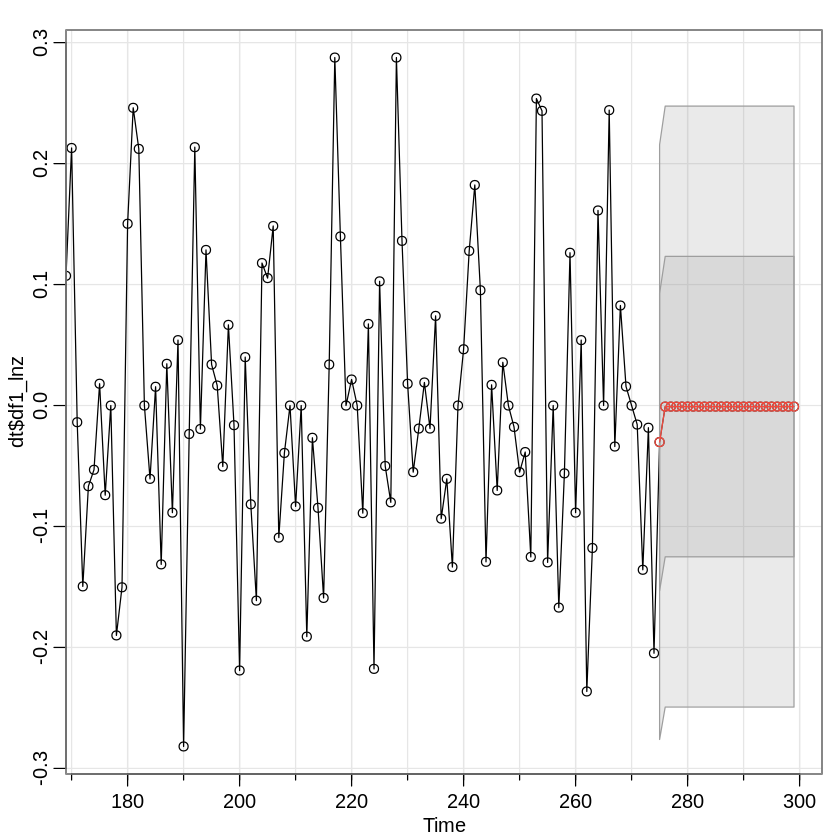

In [77]:
sarima.for(dt$df1_lnz, 25, 0,0,1)

- 차분한 값을 적용하여서도 예측값을 구해보았다. 표본평균(0)에 수렴하는 모습이었다.

#### 3 사용할 데이터 : ukcars

##### (1) 변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라. (변수변환을 시행하였으면, 아래의 분석을 변환된 값으로 수행함)

In [78]:
z=as.numeric(ukcars)
dt <- data.table(t=seq.Date(as.Date("1977-01-01"), by='quarter', length.out=length(ukcars)), z=z)

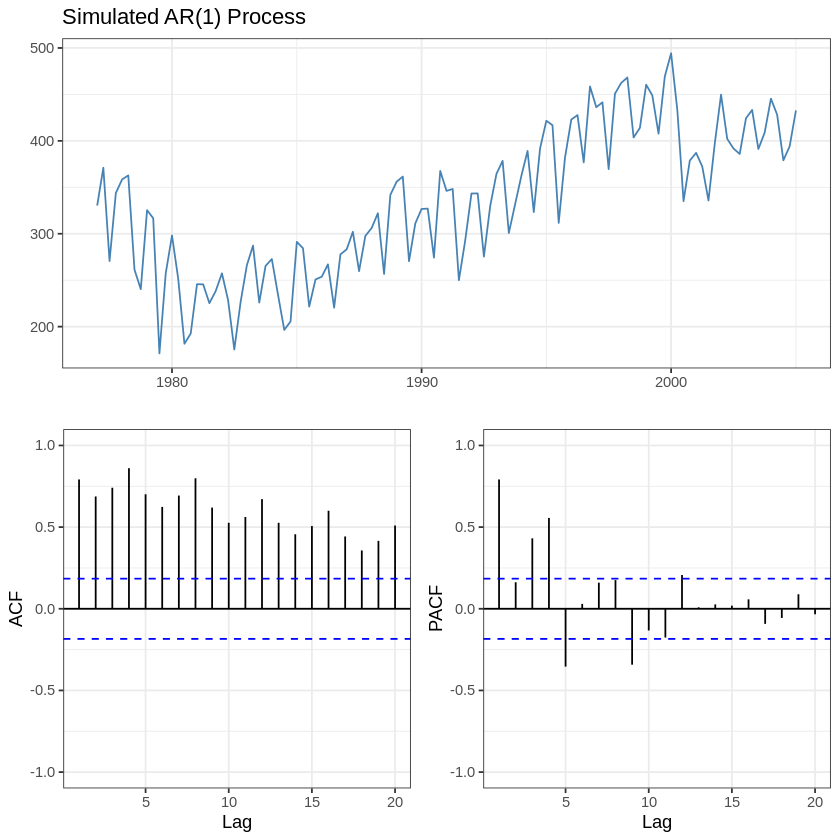

In [79]:
p3 <- ggplot(dt, aes(t, z)) + geom_line(col='steelblue') +xlab("")+ylab('')+ ggtitle('Simulated AR(1) Process')+  theme_bw()
p1 <- ggAcf(dt$z) +  theme_bw() + ylim(-1,1) +  theme(plot.title = element_blank())
p2 <- ggPacf(dt$z) + theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2, layout_matrix = rbind(c(1,1), c(2,3)))

- 분산이 커지고 있지는 않다. 그래서 log 변환은 필요하지 않아 보인다.

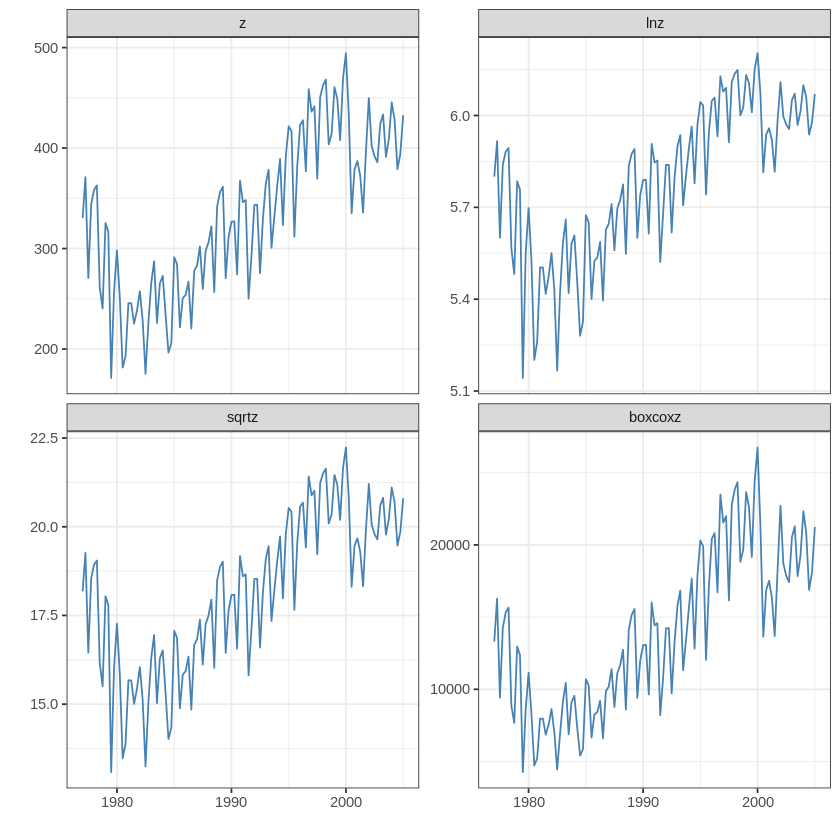

In [80]:
dt[, lnz := log(z)]
dt[, sqrtz := sqrt(z)]
dt[, boxcoxz := BoxCox(z,lambda= BoxCox.lambda(z))]
melt.dt <- melt(dt, id=1)
ggplot(melt.dt, aes(t, value)) +  geom_line(col='steelblue') + xlab("")+ylab('')+  facet_wrap(variable~.,nrow=2, scales = "free_y")+ theme_bw()

In [81]:
adfTest(dt$z, lags = 0, type = "ct")
adfTest(dt$z, lags = 1, type = "ct")
adfTest(dt$z, lags = 2, type = "ct")

Warning message in adfTest(dt$z, lags = 0, type = "ct"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -6.179
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:49 2021 by user: 


Warning message in adfTest(dt$z, lags = 1, type = "ct"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -5.8373
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:49 2021 by user: 



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -3.5541
  P VALUE:
    0.04051 

Description:
 Tue Dec 14 20:25:49 2021 by user: 


- 단위근 검정 결과 모두 귀무가설 기각 못해서 단위근 있다 할 수 있음
- 즉 아직 정상성을 만족하지 못한다.

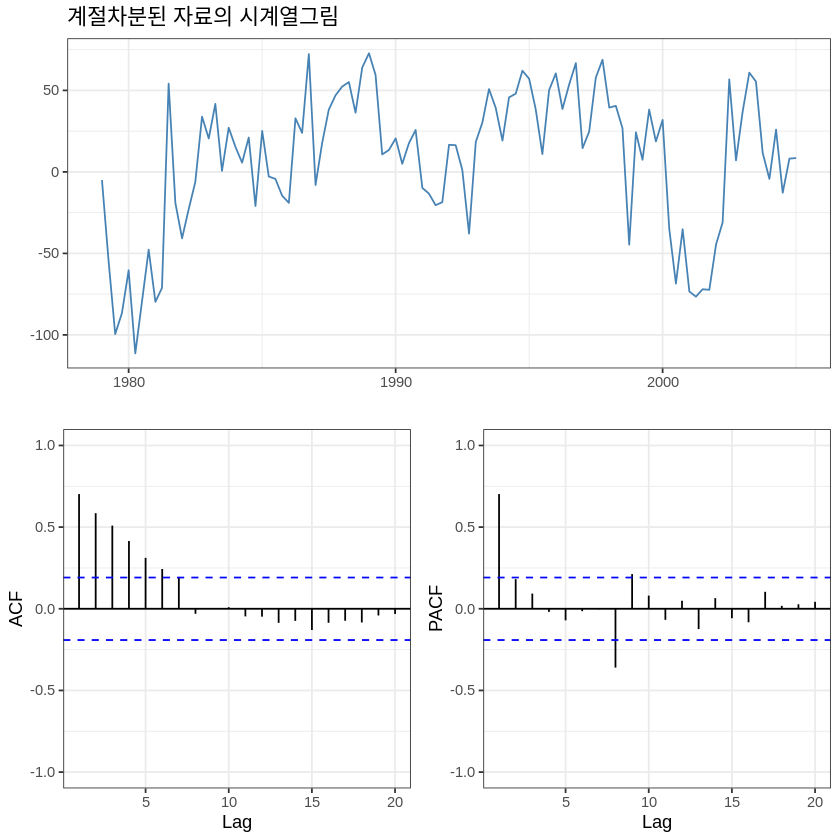

In [82]:
dt[, df8_z := c(rep(0,8), diff(z,8))]
sdt <- dt[-(1:8)]
p3 <- ggplot(sdt, aes(t, df8_z)) + geom_line(col='steelblue') +xlab("")+ylab('')+ ggtitle('계절차분된 자료의 시계열그림')+theme_bw()
p1 <- ggAcf(sdt$df8_z) + theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(sdt$df8_z) +  theme_bw() +ylim(-1,1) +theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,   layout_matrix = rbind(c(1,1), c(2,3)))

In [83]:
adfTest(sdt$df8_z, lags = 0, type = "c")
adfTest(sdt$df8_z, lags = 1, type = "c")
adfTest(sdt$df8_z, lags = 2, type = "c")

Warning message in adfTest(sdt$df8_z, lags = 0, type = "c"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -4.2254
  P VALUE:
    0.01 

Description:
 Tue Dec 14 20:25:49 2021 by user: 



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -3.2944
  P VALUE:
    0.01947 

Description:
 Tue Dec 14 20:25:49 2021 by user: 



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -3.0815
  P VALUE:
    0.03284 

Description:
 Tue Dec 14 20:25:49 2021 by user: 


- 단위근 검정 귀무가설 기각하며, 단위근이 없다는 결과가 나오고, 차분은 필요 없다.
- 정상성을 만족한다.
- PACF 1시차에서 절단되며, ACF 가 지수적으로 빠르게 감소하고 있었다.

##### (2) 마지막 2년동안의 데이터는 test데이터, 나머지는 train 데이터로 분할하여라.

In [84]:
dt_train <- dt[1:(length(z)-8),]
dt_test <- dt[(length(z)-7):length(z),]

In [85]:
head(dt_train)

t,z,lnz,sqrtz,boxcoxz,df8_z
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1977-01-01,330.371,5.800216,18.17611,13308.94,0
1977-04-01,371.051,5.916340,19.26268,16273.84,0
1977-07-01,270.670,5.600900,16.45205,9423.63,0
1977-10-01,343.880,5.840293,18.54400,14265.55,0
1978-01-01,358.491,5.881904,18.93386,15331.61,0
1978-04-01,362.822,5.893912,19.04789,15653.83,0


In [86]:
dt_test

t,z,lnz,sqrtz,boxcoxz,df8_z
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2003-04-01,433.280,6.071384,20.81538,21286.88,60.885
2003-07-01,391.213,5.969252,19.77911,17835.70,55.423
2003-10-01,408.740,6.013079,20.21732,19242.26,11.660
2004-01-01,445.458,6.099103,21.10588,22333.74,-4.297
2004-04-01,428.202,6.059595,20.69304,20856.64,25.950
2004-07-01,379.048,5.937663,19.46916,16886.09,-12.799
2004-10-01,394.042,5.976458,19.85049,18059.67,8.152
2005-01-01,432.796,6.070266,20.80375,21245.71,8.471


##### (3) 이동평균을 이용하여 마지막 2년을 예측하여라

In [87]:
mean_dt <- rollmean(dt_train[,6], 10, fill = list(NA, NULL, NA))

In [88]:
colnames(mean_dt)=c("mean_z")

In [89]:
head(cbind(dt_train[,c(1,6)],mean_dt))

t,df8_z,mean_z
<date>,<dbl>,<dbl>
1977-01-01,0,NA
1977-04-01,0,NA
1977-07-01,0,NA
1977-10-01,0,NA
1978-01-01,0,-5.9340
1978-04-01,0,-15.8857


Warning message:
“Removed 9 row(s) containing missing values (geom_path).”


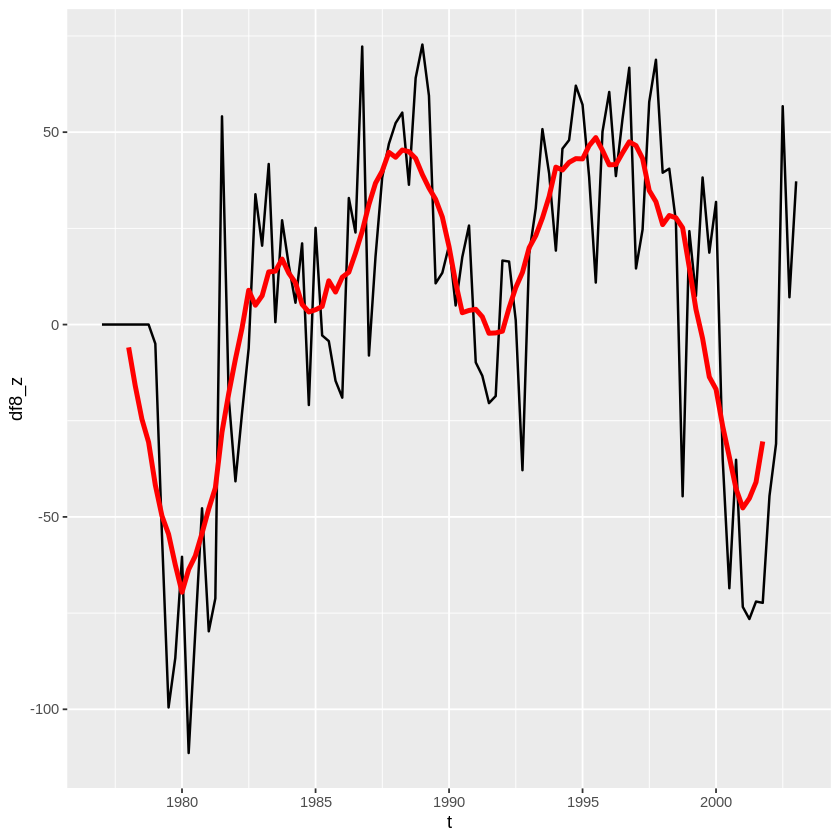

In [90]:
ggplot(data = cbind(dt_train[,c(1,6)],mean_dt), aes(x = t, y = df8_z))+
  geom_line(color = "black", size = 0.7)+
  geom_line(aes(t, mean_z), color = 'red', size = 1.4)

In [91]:
fit1 <- forecast(ts(as.numeric(mean_dt),frequency=4,start=c(1978,1)) , h=9)
fit1

Warning message in ets(object, lambda = lambda, biasadj = biasadj, allow.multiplicative.trend = allow.multiplicative.trend, :
“Missing values encountered. Using longest contiguous portion of time series”


        Point Forecast     Lo 80      Hi 80     Lo 95      Hi 95
2003 Q1    -23.1893703 -28.37159 -18.007150 -31.11489 -15.263848
2003 Q2    -16.7120877 -26.40044  -7.023737 -31.52914  -1.895034
2003 Q3    -11.5302584 -26.26100   3.200481 -34.05898  10.998464
2003 Q4     -7.3847926 -27.31520  12.545618 -37.86573  23.096140
2004 Q1     -4.0684178 -29.18677  21.049938 -42.48363  34.346792
2004 Q2     -1.4153165 -31.62171  28.791074 -47.61200  44.781372
2004 Q3      0.7071659 -34.44031  35.854642 -53.04626  54.460592
2004 Q4      2.4051528 -37.51290  42.323201 -58.64423  63.454539
2005 Q1      3.7635432 -40.74505  48.272138 -64.30648  71.833565

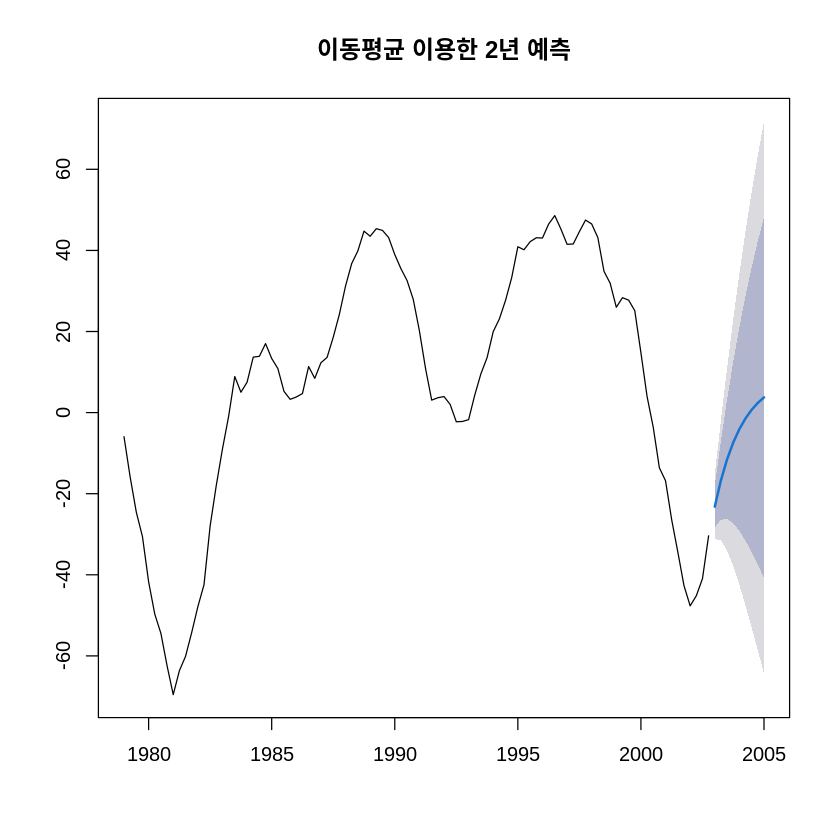

In [92]:
plot(fit1, main="이동평균 이용한 2년 예측")

##### (4) 지수평활법을 이용하여 마지막 2년을 예측하여라

In [93]:
ukcars_series <- ts(dt_train[,6], start = c(1977, 1), frequency = 4)

In [94]:
fit2=HoltWinters(ukcars_series, seasonal="additive") 
fit2

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = ukcars_series, seasonal = "additive")

Smoothing parameters:
 alpha: 0.5934982
 beta : 0
 gamma: 0

Coefficients:
       [,1]
a  26.61507
b   0.00000
s1  0.00000
s2  0.00000
s3  0.00000
s4  0.00000

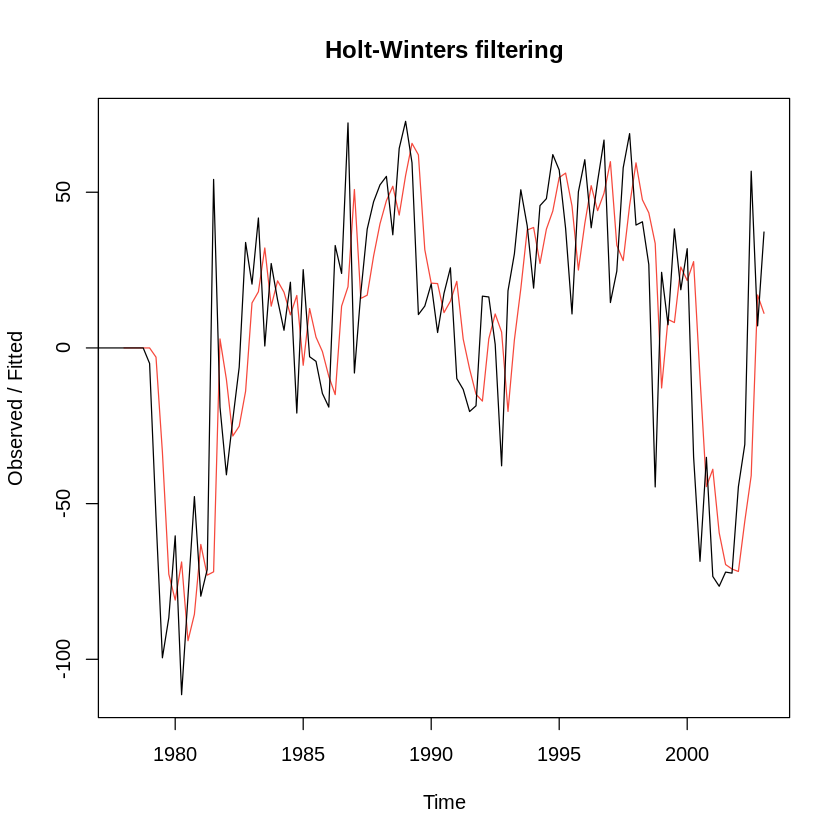

In [95]:
plot(fit2)

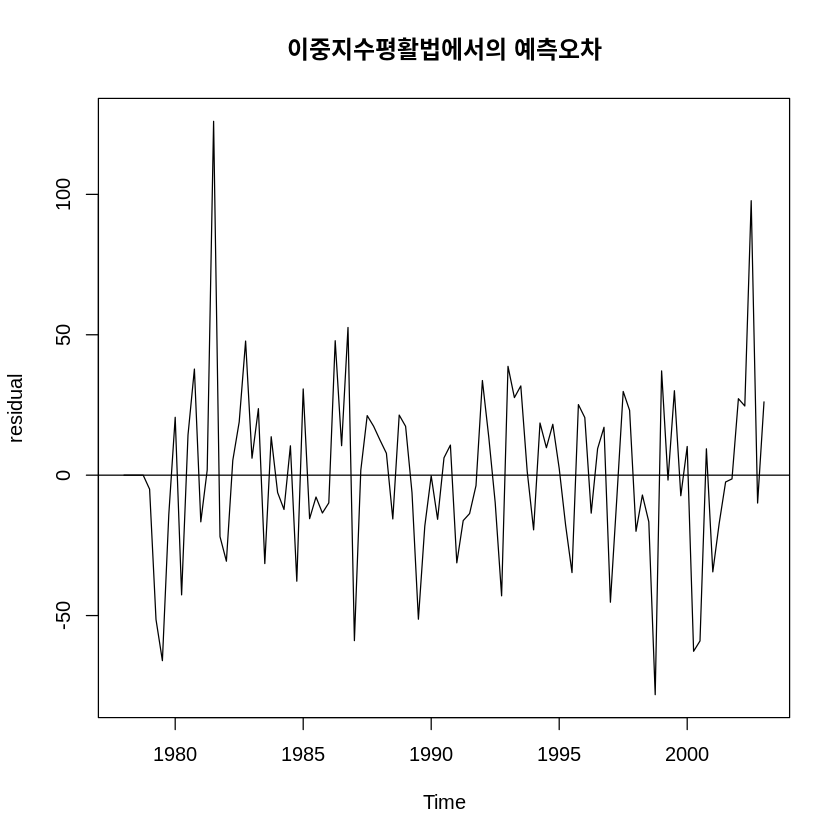

In [96]:
ts.plot(resid(fit2), ylab="residual",  main="이중지수평활법에서의 예측오차"); abline(h=0)

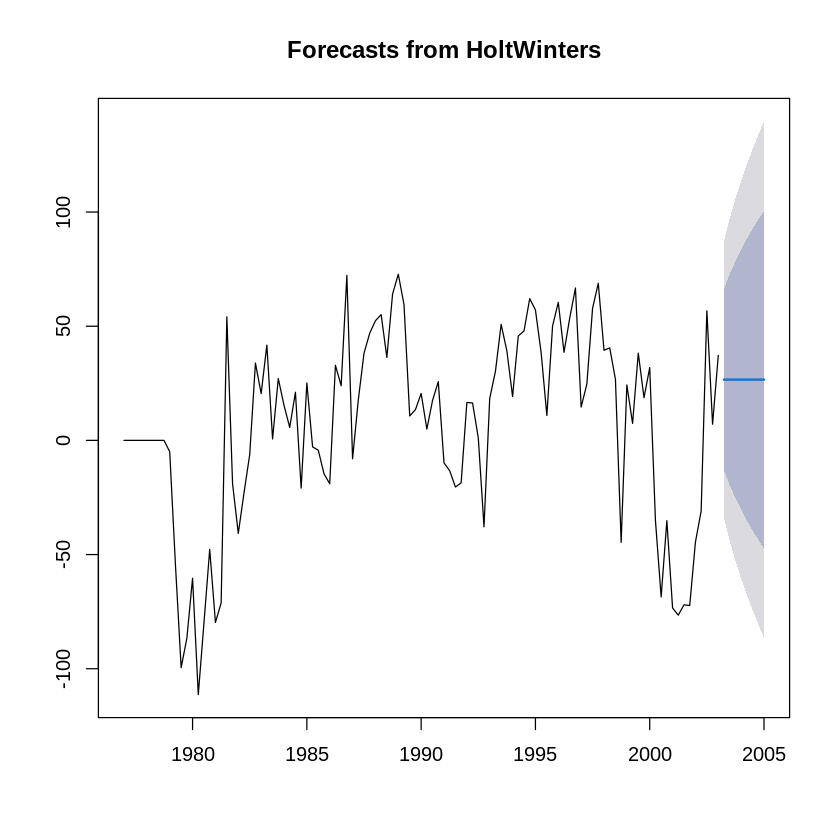

In [97]:
fit2_2=forecast(fit2, h=8)
plot(fit2_2)

##### (5) 계절형 ARIMA 모형을 적합하여 마지막 2년을 예측하여라.

- (1)의 계절차분한 데이터에서 AR(1)이 적절하다는 것을 PACF가 1시차에서 절단되고, ACF가 빠르게 감소한다는 것을 보고 예상했다.

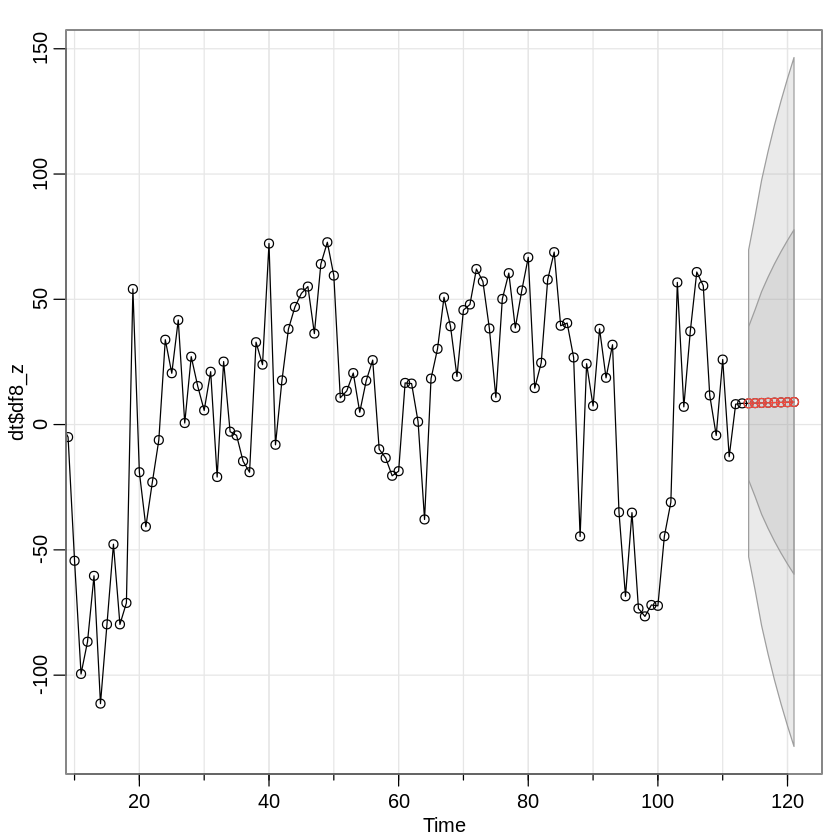

In [98]:
fit3=sarima.for(dt$df8_z, 8, 1,1,0) 

In [99]:
head(fit3$pred + qnorm(0.975)*fit3$se)  ##95% 신뢰구간 상한
head(fit3$pred - qnorm(0.975)*fit3$se)  ##95% 신뢰구간 하한

A Time Series:
[1]  68.47040  81.68555  95.72767 107.03779 117.40279 126.81431

A Time Series:
[1]  -51.52585  -64.54557  -78.45081  -89.60628  -99.82203 -109.08265

##### (6) 예측값과 실제값을 이용하여 (3)-(5) 모형 중 가장 좋은 모형을 선택하여라

In [100]:
dt_test

t,z,lnz,sqrtz,boxcoxz,df8_z
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2003-04-01,433.280,6.071384,20.81538,21286.88,60.885
2003-07-01,391.213,5.969252,19.77911,17835.70,55.423
2003-10-01,408.740,6.013079,20.21732,19242.26,11.660
2004-01-01,445.458,6.099103,21.10588,22333.74,-4.297
2004-04-01,428.202,6.059595,20.69304,20856.64,25.950
2004-07-01,379.048,5.937663,19.46916,16886.09,-12.799
2004-10-01,394.042,5.976458,19.85049,18059.67,8.152
2005-01-01,432.796,6.070266,20.80375,21245.71,8.471


In [101]:
fit1
fit1_1=data.frame(fit1)

        Point Forecast     Lo 80      Hi 80     Lo 95      Hi 95
2003 Q1    -23.1893703 -28.37159 -18.007150 -31.11489 -15.263848
2003 Q2    -16.7120877 -26.40044  -7.023737 -31.52914  -1.895034
2003 Q3    -11.5302584 -26.26100   3.200481 -34.05898  10.998464
2003 Q4     -7.3847926 -27.31520  12.545618 -37.86573  23.096140
2004 Q1     -4.0684178 -29.18677  21.049938 -42.48363  34.346792
2004 Q2     -1.4153165 -31.62171  28.791074 -47.61200  44.781372
2004 Q3      0.7071659 -34.44031  35.854642 -53.04626  54.460592
2004 Q4      2.4051528 -37.51290  42.323201 -58.64423  63.454539
2005 Q1      3.7635432 -40.74505  48.272138 -64.30648  71.833565

In [102]:
fit1_1[c(2,3,4,5,6,7,8,9),1]

[1] -16.7120877 -11.5302584  -7.3847926  -4.0684178  -1.4153165   0.7071659
[7]   2.4051528   3.7635432

In [103]:
diff_fit1=sum(abs((dt_test[,6] - fit1_1[c(2,3,4,5,6,7,8,9),1])/dt_test[,6]))/8*100

In [104]:
RMSE_fit1=sqrt(sum((dt_test[,6] - fit1_1[c(2,3,4,5,6,7,8,9),1])**2)/8)

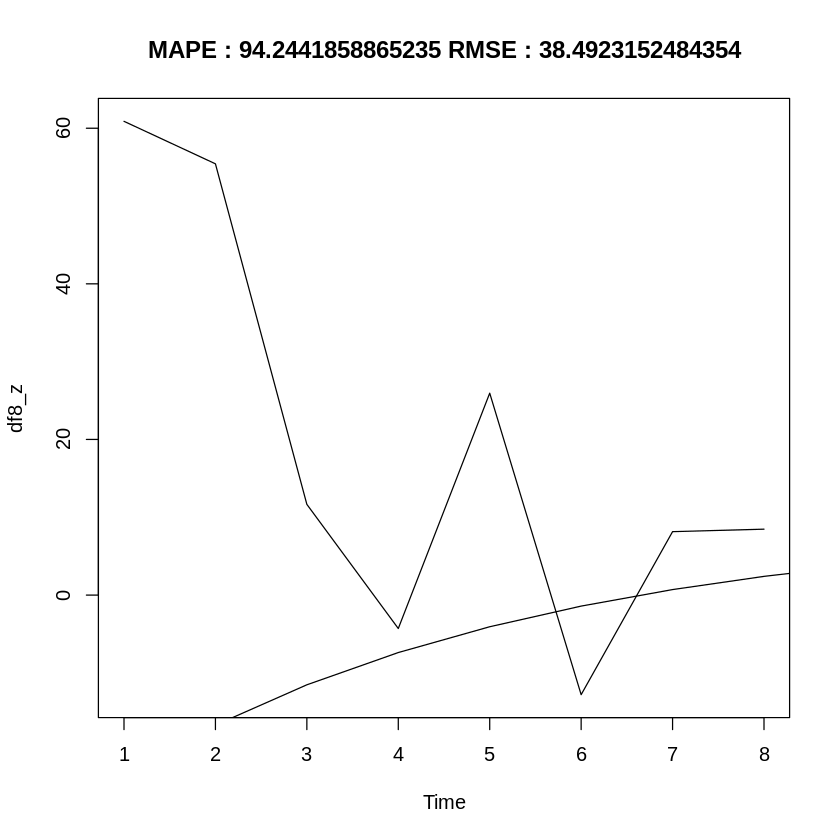

In [105]:
plot.ts(dt_test[,6])
lines(fit1_1$Point.Forecast)
title(paste0("MAPE : ",diff_fit1," RMSE : ",RMSE_fit1))

- 이동 평균 이용한 2년 예측값

In [106]:
fit2_2
fit_2_2=data.frame(fit2_2)

        Point Forecast     Lo 80     Hi 80     Lo 95     Hi 95
2003 Q2       26.61507 -13.11443  66.34457 -34.14596  87.37610
2003 Q3       26.61507 -19.58472  72.81486 -44.04141  97.27155
2003 Q4       26.61507 -25.25407  78.48421 -52.71194 105.94208
2004 Q1       26.61507 -30.36208  83.59222 -60.52396 113.75410
2004 Q2       26.61507 -35.04839  88.27853 -67.69106 120.92120
2004 Q3       26.61507 -39.40288  92.63302 -74.35068 127.58082
2004 Q4       26.61507 -43.48741  96.71755 -80.59742 133.82756
2005 Q1       26.61507 -47.34671 100.57685 -86.49971 139.72985

In [107]:
diff_fit2=sum(abs((dt_test[,6] - fit_2_2$Point.Forecast)/dt_test[,6]))/8*100

In [108]:
RMSE_fit2=sqrt(sum((dt_test[,6] - fit_2_2$Point.Forecast)**2)/8)

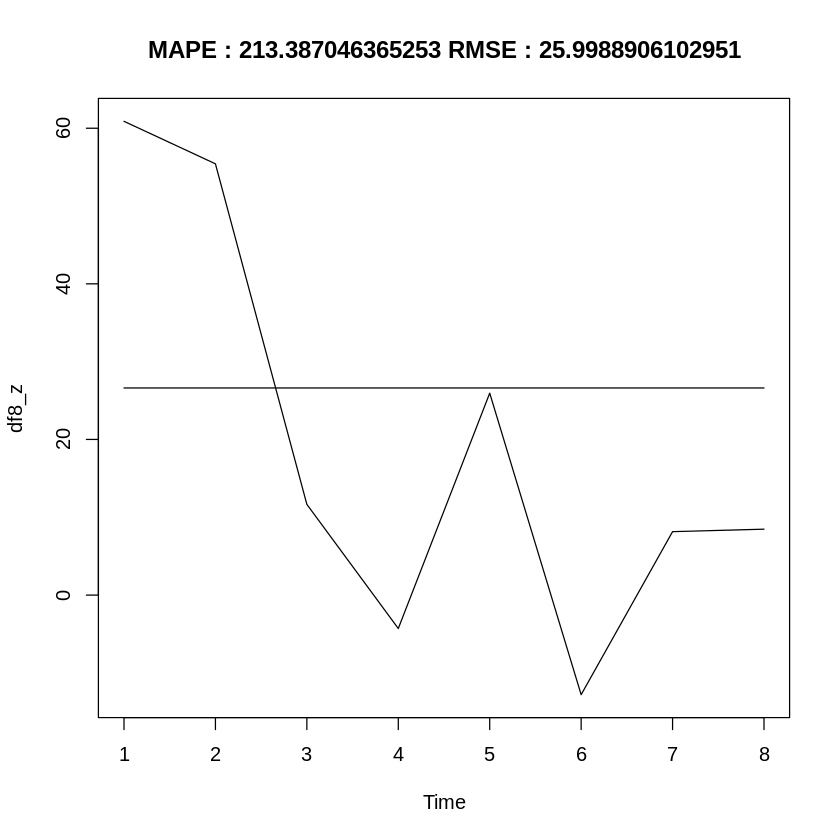

In [109]:
plot.ts(dt_test[,6])
lines(fit_2_2$Point.Forecast)
title(paste0("MAPE : ",diff_fit2," RMSE : ",RMSE_fit2))

- 계절지수평활법을 활용한 예측값

In [110]:
fit3$pred
fit3$se

A Time Series:
[1] 8.472272 8.569987 8.638427 8.715753 8.790382 8.865830 8.941030 9.016304

A Time Series:
[1] 30.61185 37.30454 44.43410 50.16523 55.41551 60.17890 64.60066 68.73609

- 계절형 ARIMA 모형을 적합한 예측값

In [111]:
diff_fit3=sum(abs((dt_test[,6] - as.numeric(fit3$pred))/dt_test[,6]))/8*100

In [112]:
RMSE_fit3=sqrt(sum((dt_test[,6] - as.numeric(fit3$pred))**2)/8)

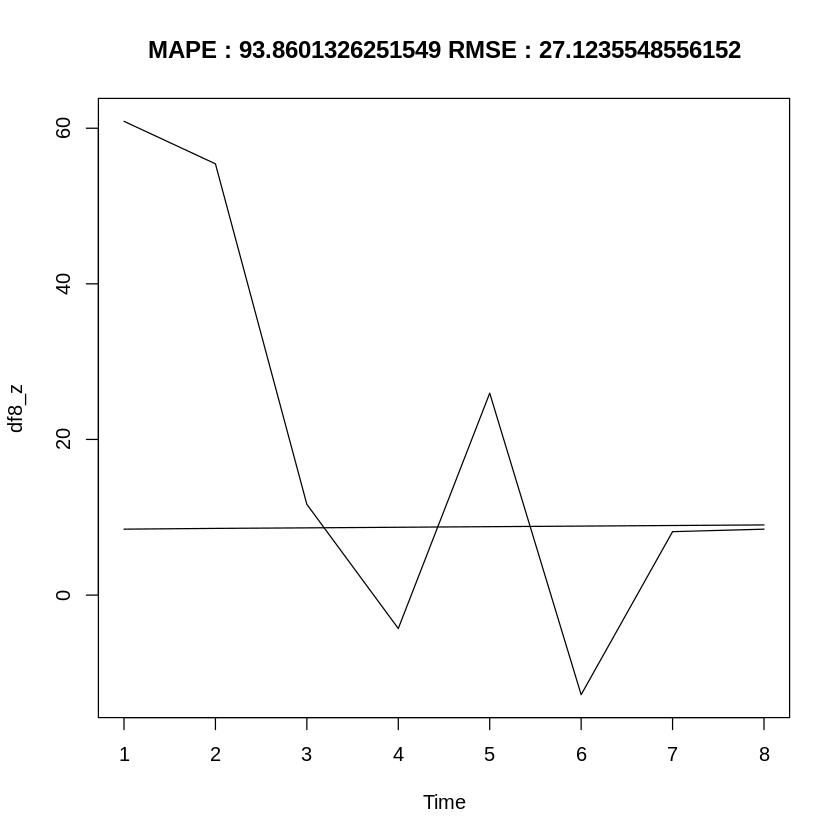

In [113]:
plot.ts(dt_test[,6])
lines(as.numeric(fit3$pred))
title(paste0("MAPE : ",diff_fit3," RMSE : ",RMSE_fit3))

- 계절형 ARIMA 에서의 2년간 예측값의 MAPE 값이 가장 작다.
- (5) 가 가장 좋은 모형으로 선택하겠다.